## End-to-End Object Detection with Transformers
* [DETR paper](https://arxiv.org/abs/2005.12872)
* [DETR github](https://github.com/facebookresearch/detr)

## The DETR model
* [facebookresearch/detr/models](https://github.com/facebookresearch/detr/tree/main/models)
* [models](../models/)

### DETR 架構組成
1. CNN backbone
    * 取得輸入影像的 feature map
    * [class Backbone(BackboneBase)](../models/backbone.py)
2. Transformer
    * 做物件偵測
    * [class Transformer(nn.Module)](../models/transformer.py)
3. feed forward network (FFN)
    * 預測數值 (類別機率、bounding box 座標)
    * [class MLP(nn.Module)](../models/detr.py)
    * [nn.Linear](../models/detr.py)

*<u>論文內容</u>*
>It
contains three main components, which we describe below: <span style="color:darkorange">a CNN backbone</span> to
extract a compact feature representation, <span style="color:darkorange">an encoder-decoder transformer</span>, and
a simple <span style="color:darkorange">feed forward network (FFN)</span> that makes the final detection prediction.

> Fig. $2$ \
>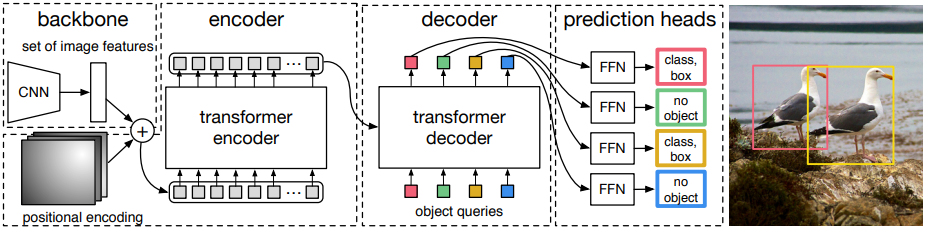

### Backbone

DETR 的論文使用 ResNet backbone with frozen BatchNorm
* code
    * [def build_backbone(args)](../models/backbone.py)

### DETR 的 DataLoader 要注意的細節

[misc.py](../util/misc.py)
> ```python
> def collate_fn(batch):
>     batch = list(zip(*batch))
>     batch[0] = nested_tensor_from_tensor_list(batch[0])
>     return tuple(batch)
> ```

> ``` python
> def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
>     # TODO make this more general
>     if tensor_list[0].ndim == 3:
>         if torchvision._is_tracing():
>             # nested_tensor_from_tensor_list() does not export well to ONNX
>             # call _onnx_nested_tensor_from_tensor_list() instead
>             return _onnx_nested_tensor_from_tensor_list(tensor_list)
> 
>         # TODO make it support different-sized images
>         max_size = _max_by_axis([list(img.shape) for img in tensor_list])
>         # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
>         batch_shape = [len(tensor_list)] + max_size
>         b, c, h, w = batch_shape
>         dtype = tensor_list[0].dtype
>         device = tensor_list[0].device
>         tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
>         mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
>         for img, pad_img, m in zip(tensor_list, tensor, mask):
>             pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
>             m[: img.shape[1], :img.shape[2]] = False
>     else:
>         raise ValueError('not supported')
>     return NestedTensor(tensor, mask)
> ```
* DataLoder 會把每一個 batch 的影像都用 0 去做 padding 成那一個 batch 裡最大影像

*<u>論文內容</u>*

>Starting from the initial image $x_{img}\in\mathbb{R}^{3{\times}H_{0}{\times}W_{0}}$ (with 3 color channels $^{\textcolor{red}{2}}$), a conventional CNN backbone generates a lower-resolution activation map $f\in\mathbb{R}^{C{\times}H{\times}W}$. Typical values we use are $C = 2048$ and $H, W ={H_{0} \over 32}, {W_{0} \over 32}$.
>
>---
>$^{2}$ The input images are batched together, applying $0$-padding adequately to ensure they all have the same dimensions $(H_{0}, W_{0})$ as the largest image of the batch.

### Backbone 到 Transformer Encoder

[facebookresearch/detr/models/detr.py](https://github.com/facebookresearch/detr/blob/main/models/detr.py#L21) \
[loacal.../detr.py](../models/detr.py)
>```python
> class DETR(nn.Module):
>     def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
>         self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
>```
* `input_proj` 為 Conv2d $1{\times}1$ 用來壓縮 backbone 輸出的 feature map

>```python
> class DETR(nn.Module):
>     def forward(self, samples: NestedTensor):
>         features, pos = self.backbone(samples)
>     
>         src, mask = features[-1].decompose()
>         hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]
>```
*  backbone 輸出的 feature map 經過 `input_proj` ，輸入到 transformer

[facebookresearch/detr/models/transformer.py](https://github.com/facebookresearch/detr/blob/main/models/transformer.py#L47) \
[loacal.../transformer.py](../models/transformer.py)
>```python
> class Transformer(nn.Module):
>     def forward(self, src, mask, query_embed, pos_embed):
>         # flatten NxCxHxW to HWxNxC
>         bs, c, h, w = src.shape
>         src = src.flatten(2).permute(2, 0, 1)
>```
* 這裡將 2D feature map 變成 1維，並調整 channel ，放到 tensor 第三維的地方，才會成為 encoder 的輸入

*<u>論文內容</u>*
>First, a $1{\times}1$ convolution reduces the channel dimension
>of the high-level activation map $f$ from $C$ to a smaller dimension $d$. creating a
>new feature map $z_{0}\in\mathbb{R}>^{d \times H \times W}$. The encoder expects a sequence as input, hence
>we collapse the spatial dimensions of $z_{0}$ into one dimension, resulting in a $d{\times}HW$
>feature map.

### Transformer

#### Encoder

* **input:**
    1. backbone 壓縮後的 feature map
    2. spatial positional encoding
* **output:** 
    1. feature map self attention 後的結果

[facebookresearch/detr/models/transformer.py](https://github.com/facebookresearch/detr/blob/main/models/transformer.py#L127) \
[loacal.../transformer.py](../models/transformer.py)
>```python
>class TransformerEncoder(nn.Module):
>class TransformerEncoderLayer(nn.Module):
>```

* EncoderLayer 架構圖
* $N{\times}$ 代表有$N$個 EncoderLayers \
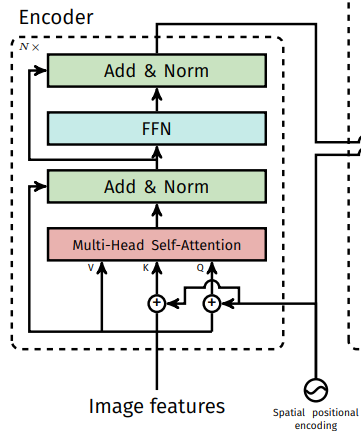
* TransformerEncoder 就是很多層 TransformerEncoderLayer ， 所以**實作細節看 TransformerEncoderLayer 就好了**
* 輸入的 feature map 跟 Spatial positional encoding 做 self-attention，**學習到 feature map 上有哪一些向量之間的關聯性是比較強，看重關聯性強的地方的特徵**，輸出是做 attention 計算後的結果

[facebookresearch/detr/models/transformer.py](https://github.com/facebookresearch/detr/blob/main/models/transformer.py#L127) \
[loacal.../transformer.py](../models/transformer.py)
>```python
> class TransformerEncoderLayer(nn.Module):
>      def with_pos_embed(self, tensor, pos: Optional[Tensor]):
>          return tensor if pos is None else tensor + pos
>```
* 將 Image features 與 [Spatial positional encoding](#positional-encoding) 將加
* 根據[參考資料](https://youtu.be/ugWDIIOHtPA?si=z6DTMJrjzc8PeSj0&t=1880)的說明，為什麼用加而不是 concat。因為矩陣運算 concat 可以拆成兩個小部分矩陣相乘後再相加 \
    **position encoding 預設不是用學的而是給定的 vector**


>```python
>class TransformerEncoderLayer(nn.Module):
>     def forward_post(self, src, src_mask=None, src_key_padding_mask=None, pos=None):
>     def forward_pre(self, src, src_mask=None, src_key_padding_mask=None, pos=None):
>     def forward(self, src, src_mask=None, src_key_padding_mask=None, pos=None):
>```
* EncoderLayer 的主要流程，不包括 normalize 的話
    1. image feature 與 Spatial positional encoding 將加
    2. 做 self-attention，學習 image feature 之間的相關性
    3. dropout self-attention 後的結果
    4. FFN 中的過程: 做 Relu 後 dropout
    5. residual connection
* `forward_post` 跟 `forward_pre` 只差對輸入的 src 做 normalize 的順序不同，可以在 `forward` 裡選擇要用哪一個
* `EncoderLayer` 主要一樣由 `MultiheadAttention`, `Linear`, `Dropout` 這三個組成，但每一個 `MultiheadAttention` 的輸入都會加上 query_pos($W^{q}$) ，是主要 DETR TransformerEncoder 與原本不同的地方

#### Decoder
* **input:** 
    1. tgt($\mathinner{object{\space}queries}$): 初始為 query_pos 。為了為了讓每一個 "output embedding" 不一樣，不會受到 [permutation-invariant](https://medium.com/@he165076373/what-is-permutation-invariance-a-brief-introduction-58ecb7a49334) 性質影響。\
        query_pos: `self.query_embed=nn.Embedding` 的權重
    2. memory: Eecoder 的輸出
* **output:**
    1. $\mathnormal{N}個\mathinner{object{\space}queries}$ 稱作 "output embedding" ，也就是 query_pos 經過 "self attention", "cross attention" 後的結果 \
    <span style="color:gray">**$\mathnormal{COCO}$ 資料集的話預設 $\mathnormal{N}=100$**</span>

[facebookresearch/detr/models/transformer.py](https://github.com/facebookresearch/detr/blob/main/models/transformer.py#L187) \
[loacal.../transformer.py](../models/transformer.py)
>```python
> class TransformerDecoder(nn.Module):
> class TransformerDecoderLayer(nn.Module):
>```

* DecoderLayer 架構圖
* $N{\times}$ 代表有$N$個 DecoderLayers \
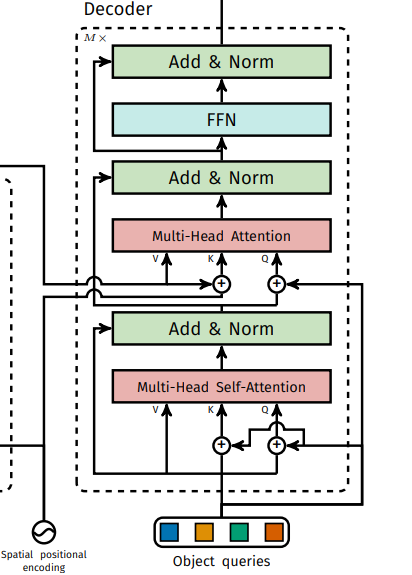


* 在 training 中學習 object queries
* **<u>object queries 跟著整個 Transformer 一起 init ，是用 `nn.init.xavier_uniform` 做初始化</u>** \
    *Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)*
* self-attention，如果是文字的話這裡是用來考慮前面decoder生成文字的關係， $N$個 objects queries 可能會去尋找所有 objects queries 跟自己有關的地方(例如相同一隻斑馬的地方)
* cross-attention，如果是文字的話這裡是用 encoder 的資訊產生與 decoder 生成的文字求出下一個要生成什麼字，這裡 decoder 看到 encoder 輸出的 image feature 之間關聯性，用 object query 去學習這一個 query 要找(生成)的是什麼 feature(類別與bbox)，
* 從結果來看 object query 會被 position 影響，每一個 object query 都大機率偏向關注於 image 其中一個位置，跟偏向某一種大小的bbox
* 如果我們不知道 test data 會有多少個，在文字的情況可以另外訓練一個 model 預測句子要多少字

[self-attention參考資料](https://medium.com/ml-note/autoencoder-%E4%B8%89-self-attention-transformer-c37f719d222)

*<u>論文內容</u>*
>Since the decoder is also permutation-invariant,
><span style="color:darkorange">the N input embeddings must be different to produce different results. These input embeddings are learnt positional encodings that we refer to as object queries</span>,
>and similarly to the encoder, we add them to the input of each attention layer.
><span style="color:darkorange">The N object queries are transformed into an output embedding by the decoder.</span>


[facebookresearch/detr/models/transformer.py](https://github.com/facebookresearch/detr/blob/main/models/transformer.py#L187) \
[loacal.../transformer.py](../models/transformer.py)
>```python
> class TransformerDecoderLayer(nn.Module):
>      def forward_post(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, pos=None, query_pos=None):
>      def forward_pre(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, pos=None, query_pos=None):
>      def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, pos=None, query_pos=None):
>```
* 跟 Encoder 一樣 `forward_post` 跟 `forward_pre` 只差對輸入的 src 做 normalize 的順序不同，可以在 `forward` 裡選擇要用哪一個
* `DecoderLayer` 主要一樣由 `MultiheadAttention`, `Linear`, `Dropout` 這三個組成，但每一個 `MultiheadAttention` 的輸入都會加上 position encoding ，是主要 DETR Transformer 與原本 Transformer 不同的地方
* DecoderLayer `forward_post` 大致流程(不包括 normalize)
    1. `tgt2` <= 先做 `self_attn` "self attention"
    2. `tgt` <= `tgt` + dropout(`tgt2`)
    3. `tgt2` <= 做 `multihead_attn` "cross attention"
    4. `tgt` <= `tgt` + dropout(`tgt2`)
    5. `tgt2` <= linear2(dropout(Relu(linear1(`tgt`)))) 對 `tgt` 做 Relu 後放到 FFN(feed forward network)
    6. `tgt` <= `tgt` + dropout(`tgt2`)

### Positional encoding

[facebookresearch/detr/models/position_encoding.py](https://github.com/facebookresearch/detr/blob/main/models/position_encoding.py) \
[local.../position_encoding.py](../models/position_encoding.py)
>```python
>class PositionEmbeddingSine(nn.Module):
>class PositionEmbeddingLearned(nn.Module):
>```

>```python
>class TransformerDecoderLayer(nn.Module):
>    def forward_post(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, pos=None, query_pos=None):
>        q = k = self.with_pos_embed(tgt, query_pos)
>        gt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
>                                   key=self.with_pos_embed(memory, pos),
>                                   value=memory, attn_mask=memory_mask,
>                                   key_padding_mask=memory_key_padding_mask)[0]
>```
* `query_pos` ="object query", `pos` ="spatial positional encodings"
* 有兩種 spatial positional encodings 
    1. 手動給的 sin cos `class PositionEmbeddingSine`
    2. 學出來的 `class PositionEmbeddingLearned`
* Decoder 每一個 attention 都要加入 Spatial positional encodings
    * Spatial positional encodings 在 Decoder 的影響較大
    * 論文實驗過不加的情況，偵測的效果會減少一定的量
* Eecoder 每一個 attention 都要加入 Spatial positional encodings
    * Spatial positional encodings 在 Eecoder 不是很重要
    * 論文實驗過不加的情況，偵測的效果會稍微減少

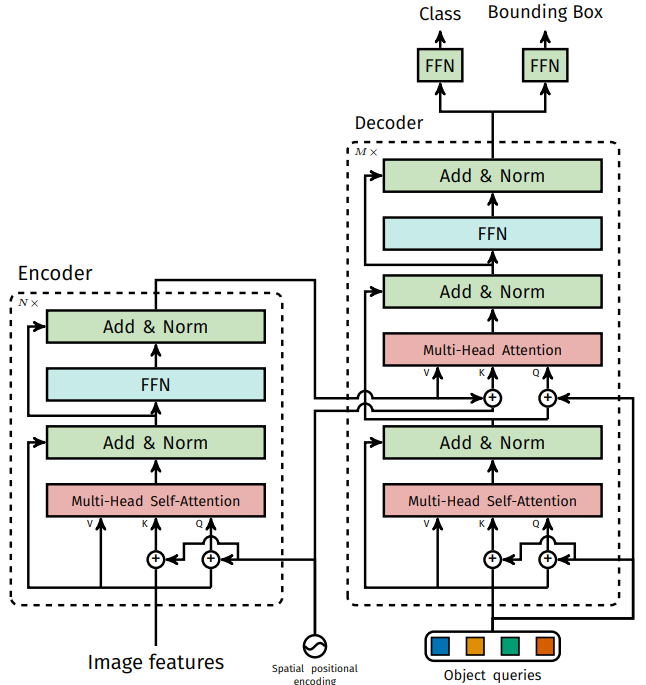

*<u>論文內容</u>*
>There are <span style="color:darkorange">two kinds</span> of positional encodings in our model: <span style="color:darkorange">spatial positional encodings</span> and <span style="color:darkorange">output positional encodings (object queries)</span>. In
>the first experiment we <span style="color:darkorange">completely remove spatial positional encodings and pass
>output positional encodings at input</span> and, interestingly, the model still achieves
>more than 32 AP, losing 7.8 AP to the baseline. Then, we <span style="color:darkorange">pass fixed sine spatial
>positional encodings and the output encodings at input once, as in the original
>transformer [47]</span>, and find that this leads to 1.4 AP drop compared to passing
>the positional encodings directly in attention. Learned spatial encodings passed
>to the attentions give similar results. Surprisingly, we find that <span style="color:darkorange">not passing any
>spatial encodings in the encoder</span> only leads to a minor AP drop of 1.3 AP. When
>we pass the encodings to the attentions, they are shared across all layers, and
>the output encodings (object queries) are always learned.

>* Table 3: Results for different positional encodings compared to <span style="color:darkorange">the baseline (last row), which has fixed sine pos. encodings passed at every attention layer in both the encoder and the decoder</span>. Learned embeddings are shared between all layers. Not using spatial positional encodings leads to a significant drop in AP. Interestingly, <span style="color:darkorange">passing them in decoder only leads to a minor AP drop</span>. All these models use learned output positional encodings.
>
>|spatial pos. enc.$\newline$ encoder $\hspace{4pt}$ decoder |output pos. enc. $\newline$ decoder| $AP$ $\hspace{10pt}$ ${\varDelta}$ | $AP_{50}$ $\hspace{10pt}$ ${\varDelta}$ |
>|:--:|:--:|:--:|:--:|
>|none $\hspace{8pt}$ none|learned at input|$32.8\hspace{10pt}-7.8$|$55.2\hspace{10pt}-6.5$|
>|sine at input $\hspace{8pt}$ sine at input|learned at input|$39.2\hspace{10pt}{-1.4}$|$60.0\hspace{10pt}-1.6$|
>|learned at attn. $\hspace{8pt}$ learned at attn.|learned at attn.|$39.6\hspace{10pt}-1.0$|$60.7\hspace{10pt}-0.9$|
>|none $\hspace{8pt}$ sine at attn.|learned at attn.|$39.3\hspace{10pt}-1.3$|$60.3\hspace{10pt}-1.4$|
>|sine at attn. $\hspace{8pt}$ sine at attn.|learned at attn.|$\bold{40.6}\hspace{16pt}-$|$\bold{61.6}\hspace{16pt}-$|


### Prediction feed-forward networks

[facebookresearch/detr/models/detr.py](https://github.com/facebookresearch/detr/blob/main/models/detr.py#L21) \
[loacal.../detr.py](../models/detr.py)
>```python
>class DETR(nn.Module):
>     def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
>         self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
>         self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
>```

* 預測頭的架構圖 \
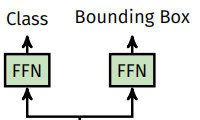
* FFN 在 pytorch 裡實作方法之一是用 nn.Linear
* nn.Linear 只用一層輸出 class 的機率
* `class MLP` 就是很多的 nn.Linear 組成用來預測 bounding box

>```python
>class DETR(nn.Module):
>    def forward(self, samples: NestedTensor):
>        hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]
>
>        outputs_class = self.class_embed(hs)
>        outputs_coord = self.bbox_embed(hs).sigmoid()
>```
1. 預測類別 `class_embed`
    * **input**
        1. transformer decoder 的輸出，$\mathnormal{N}個\mathinner{object{\space}queries}$
    * **output**
        1. 預測出來機率，數量為 `num_classes + 1` 個 \
            <span style="color:gray">**$\mathnormal{COCO}$ 資料集的話預設 91 + 1**</span> \
            **<span style="color:darkorange">要另外做 softmax ，才可以做 evaluate</span>**
2. 預測 bounding box `bbox_embed`
    * **input**
        1. transformer decoder 的輸出，$\mathnormal{N}個\mathinner{object{\space}queries}$
    * **output**
        1. 預測出來的 bounding box (vecter len 4)，輸出會做 sigmoid \
            **<span style="color:darkorange">輸出的 bounding box 還要轉換才可以對應到 image 上做 evaluate</span>**

[facebookresearch/detr/models/detr.py](https://github.com/facebookresearch/detr/blob/main/models/detr.py#L289)
>```python
> class MLP(nn.Module):
>     def forward(self, x):
>         for i, layer in enumerate(self.layers):
>             x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
>```
* bbox_embed 為 MLP 的 instance
* MLP 用來預測 bounding box ，最後一層是做 Relu 其他是 nn.Linear

### 轉換預測結果

[facebookresearch/detr/models/detr.py](https://github.com/facebookresearch/detr/blob/main/models/detr.py#L258)
>```python
>class PostProcess(nn.Module):
>    def forward(self, outputs, target_sizes):
>        out_logits, out_bbox = outputs['pred_logits'], outputs>['pred_boxes']
>
>        assert len(out_logits) == len(target_sizes)
>        assert target_sizes.shape[1] == 2
>
>        prob = F.softmax(out_logits, -1)
>        scores, labels = prob[..., :-1].max(-1)
>
>        # convert to [x0, y0, x1, y1] format
>        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
>        # and from relative [0, 1] to absolute [0, height] >coordinates
>        img_h, img_w = target_sizes.unbind(1)
>        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
>        boxes = boxes * scale_fct[:, None, :]
>```
* 主要做以下兩件事情
    1. 找到機率最大的類別
    2. bounding box 轉換成 coco 格式，並重新對應到 image 大小
* 給 `evaluate` 做使用

## DETR 的 training (fine-tune)

### Matching & cost matrix
[facebookresearch/detr/models/matcher.py](https://github.com/facebookresearch/detr/blob/main/models/matcher.py#L12) \
[local.../matcher.py](../models/matcher.py)
>```python
> class HungarianMatcher(nn.Module):
>    def forward(self, outputs, targets):
>        bs, num_queries = outputs["pred_logits"].shape[:2]
>
>        # We flatten to compute the cost matrices in a batch
>        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
>        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]
>
>        # Also concat the target labels and boxes
>        tgt_ids = torch.cat([v["labels"] for v in targets])
>        tgt_bbox = torch.cat([v["boxes"] for v in targets])
>
>        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
>        # but approximate it in 1 - proba[target class].
>        # The 1 is a constant that doesn't change the matching, it can be ommitted.
>        cost_class = -out_prob[:, tgt_ids]
>
>        # Compute the L1 cost between boxes
>        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
>
>        # Compute the giou cost betwen boxes
>        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))
>
>        # Final cost matrix
>        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
>        C = C.view(bs, num_queries, -1).cpu()
>
>        sizes = [len(v["boxes"]) for v in targets]
>        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
>        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]
>```
* 回傳裡 i 是預測 j 是對應的 target
* cost matrix 主要有三個部份
    1. `cost_class`
    2. `cost_bbox`
    3. `cost_giou`
* `linear_sum_assignment` 做 assignment ，依據 cost matrix 配對預測跟 target
* training 在算 loss 的時候會才會用到，可以在 `class SetCriterion` 裡看到使用方法

### Loss
* $\mathcal{L}_{match}(y_{i},\widehat{y}_{\sigma(i)})$ 為以下兩個部份
    1. $-\mathbb{1}_{\{c_{i}\ne\varnothing\}}\widehat{p}(c_{i})$
    2. $\mathbb{1}_{\{c_{i}\ne\varnothing\}}\mathcal{L}_{box}(b_{i},\widehat{b}_{\sigma(i)})$
        * 第2可以分成以下兩個部分的和 \
            $\mathcal{L}_{box}(b_{i},\widehat{b}_{\sigma(i)})=\lambda_{iou}\mathcal{L}_{iou}(b_{i},\widehat{b}_{\sigma(i)})+\lambda_{L1}{\lVert{b_{i},\widehat{b}_{\sigma(i)}}\rVert}_{1}$
            1. `loss_giou`: giou \
                $\lambda_{iou}\mathcal{L}_{iou}(b_{i},\widehat{b}_{\sigma(i)})$
            2. `loss_bbox`: L1 loss \
                $\lambda_{L1}{\lVert{b_{i},\widehat{b}_{\sigma(i)}}\rVert}_{1}$

[facebookresearch/detr/models/detr.py](https://github.com/facebookresearch/detr/blob/main/models/detr.py#L83) \
[loacal.../detr.py](../models/detr.py)
>```python
>class SetCriterion(nn.Module):
>     def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
>         loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
>```
* 計算預測的 class 機率與 ground truth(label) 之間做配對後的 `cross_entropy`，其中包含空物件的配對
* 論文公式
    * `loss_ce`: $-\mathbb{1}_{\{c_{i}\ne\varnothing\}}\widehat{p}(c_{i})$

>```python
>class SetCriterion(nn.Module):
>     def loss_boxes(self, outputs, targets, indices, num_boxes):
>         loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')
>        
>         losses = {}
>         losses['loss_bbox'] = loss_bbox.sum() / num_boxes
>
>         loss_giou = 1 - torch.diag(box_ops.generalized_box_iou(
>            box_ops.box_cxcywh_to_xyxy(src_boxes),
>            box_ops.box_cxcywh_to_xyxy(target_boxes)))
>         losses['loss_giou'] = loss_giou.sum() / num_boxes
>```
* 計算預測的 bounding box 與 ground truth(bbox) 之間的 loss
* 論文公式:
    * `losses['loss_bbox']`: $\lambda_{iou}\mathcal{L}_{iou}(b_{i},\widehat{b}_{\sigma(i)})$
    * `losses['loss_giou']`: $\lambda_{L1}{\lVert{b_{i},\widehat{b}_{\sigma(i)}}\rVert}_{1}$

[facebookresearch/detr/engine.py](https://github.com/facebookresearch/detr/blob/main/engine.py#L35) \
[local.../engine.py](../engine.py)
>```python
> def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
>                     data_loader: Iterable, optimizer: torch.optim.Optimizer,
>                     device: torch.device, epoch: int, max_norm: float = 0):
>     loss_dict = criterion(outputs, targets)
>     weight_dict = criterion.weight_dict
>     losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
>```

*<u>論文內容</u>*

>To find a bipartite matching between these two sets we search for a permutation of $N$ elements $\sigma\in\mathfrak{S}_N$ with the lowest cost:
>$$\tag{1}\widehat{\sigma}={argmain \atop \sigma\in\mathfrak{S}_N}\displaystyle\sum_{i=1}^N\mathcal{L}_{match}(y_{i},\widehat{y}_{\sigma(i)})$$

> With these notations we define $\mathcal{L}_{match}(y_{i},\widehat{y}_{\sigma(i)})$ as $-\mathbb{1}_{\{c_{i}\ne\varnothing\}}\widehat{p}(c_{i})+\mathbb{1}_{\{c_{i}\ne\varnothing\}}\mathcal{L}_{box}(b_{i},\widehat{b}_{\sigma(i)})$.


> Overall, our box loss is $\mathcal{L}_{box}(b_{i},\widehat{b}_{\sigma(i)})$ define as $\lambda_{iou}\mathcal{L}_{iou}(b_{i},\widehat{b}_{\sigma(i)})+\lambda_{L1}{\lVert{b_{i},\widehat{b}_{\sigma(i)}}\rVert}_{1}$ where $\lambda_{iou},\lambda_{L1}\in\mathbb{R}$ are hyperparameters. <span style="color:darkorange">These two losses are normalized by the number of objects inside the batch.</span>


### Optimizer

[facebookresearch/detr/main.py](https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L138) \
[local.../main.py](../main.py)
>```python
>def main(args):
>    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
>```
* 沿用 transformer 的 Optimizer

*<u>論文內容</u>*
>Transformers are typically trained with <span style="color:darkorange">Adam</span> or <span style="color:darkorange">Adagrad</span> optimizers with very long training schedules and dropout, and this is true for DETR as well. 

### Dataset 的準備
[fine tune with custom dataset 參考資料](https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb#scrollTo=uZxT8VAiEuBp)
* COCO 2017 detection 的格式
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

### Augmentation
[facebookresearch/detr/datasets/coco.py](https://github.com/facebookresearch/detr/blob/main/datasets/coco.py#L115) \
[local.../coco.py](../datasets/coco.py)
>```python
>def make_coco_transforms(image_set):
>    normalize = T.Compose([
>        T.ToTensor(),
>        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
>    ])
>
>    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]
>
>    if image_set == 'train':
>        return T.Compose([
>            T.RandomHorizontalFlip(),
>            T.RandomSelect(
>                T.RandomResize(scales, max_size=1333),
>                T.Compose([
>                    T.RandomResize([400, 500, 600]),
>                    T.RandomSizeCrop(384, 600),
>                    T.RandomResize(scales, max_size=1333),
>                ])
>            ),
>            normalize,
>        ])
>
>    if image_set == 'val':
>        return T.Compose([
>            T.RandomResize([800], max_size=1333),
>            normalize,
>        ])
>```

[facebookresearch/detr/datasets/coco.py](https://github.com/facebookresearch/detr/blob/main/datasets/coco.py#L17)
> ```python
> class CocoDetection(torchvision.datasets.CocoDetection):
>     def __init__(self, img_folder, ann_file, transforms, return_masks):
>         super(CocoDetection, self).__init__(img_folder, ann_file)
>         self._transforms = transforms
>         self.prepare = ConvertCocoPolysToMask(return_masks)
> 
>     def __getitem__(self, idx):
>         img, target = super(CocoDetection, self).__getitem__(idx)
>         image_id = self.ids[idx]
>         target = {'image_id': image_id, 'annotations': target}
>         img, target = self.prepare(img, target)
>         if self._transforms is not None:
>             img, target = self._transforms(img, target)
>         return img, target
> ```
* 產生 training dataset 時會用到 pytorvh transform 來做 augumentation
* 論文中提到主要的 augmentation
    1. scale augmentation
    2. random crop augmentations

* Data augmentation 範例 \
[pytorch transforms examples](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py)
> ```python
> from torchvision import tv_tensors  # we'll describe this a bit later, bare with us
> 
> boxes = tv_tensors.BoundingBoxes(
>     [
>         [15, 10, 370, 510],
>         [275, 340, 510, 510],
>         [130, 345, 210, 425]
>     ],
>     format="XYXY", canvas_size=img.shape[-2:])
> 
> transforms = v2.Compose([
>     v2.RandomResizedCrop(size=(224, 224), antialias=True),
>     v2.RandomPhotometricDistort(p=1),
>     v2.RandomHorizontalFlip(p=1),
> ])
> out_img, out_boxes = transforms(img, boxes)
> print(type(boxes), type(out_boxes))
> 
> plot([(img, boxes), (out_img, out_boxes)])
> ```
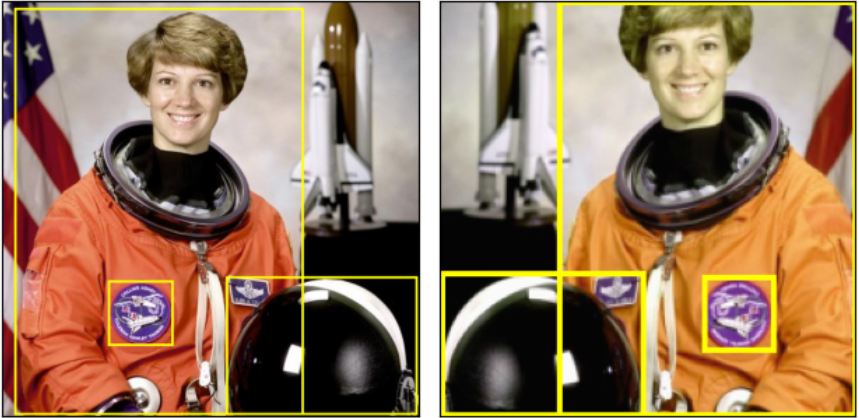

*<u>論文內容</u>*
>We use <span style="color:darkorange">scale augmentation</span>, resizing the input images such that the shortest side is at least $480$ and at most $800$ pixels while the longest at most $1333$ [50]. To help learning global relationships through the self-attention of the encoder, we also apply <span style="color:darkorange">random crop augmentations during training</span>, improving the performance by approximately $1$ $\mathrm{AP}$. Specifically, a train image is cropped with probability $0.5$ to a random rectangular patch which is then resized again to $800\text{\textendash}1333$. 

### 開始做 training (fine-tune)

* fine-tune 的參考資料
    * [facebookresearch/detr training](https://github.com/facebookresearch/detr#training)
    * [Recommendations for training Detr on custom dataset?](https://github.com/facebookresearch/detr/issues/9)
    * [fine-tune with custom dataset參考資料](https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb#scrollTo=uZxT8VAiEuBp)

## DETR 的評估 (evaluate object detection part)

* The following 12 metrics are used for characterizing the performance of an object detector on COCO: \
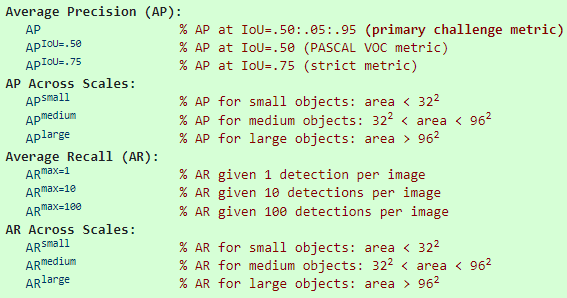
* [cocodataset 參考資料](https://cocodataset.org/#detection-eval)

* Table 1. \
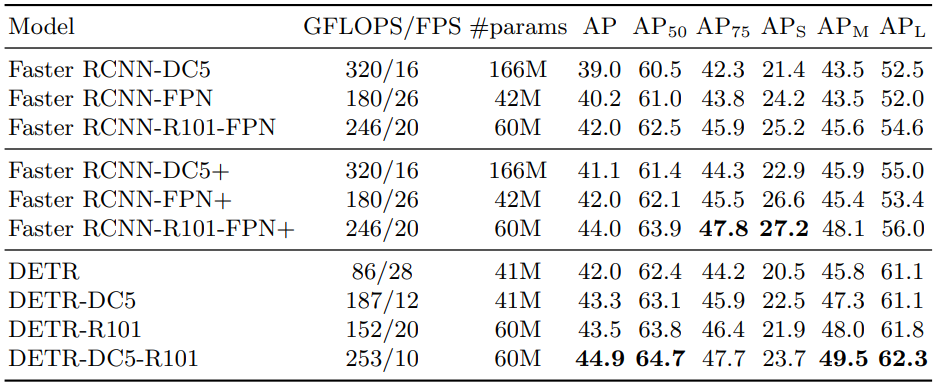

## DETR 的實驗

* Fig 7. \
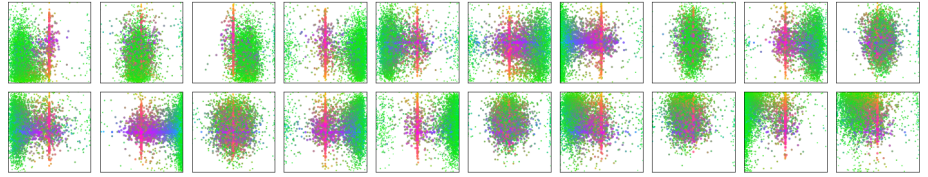

* object query 在影像中預測中心相對於影像的位置
  * 綠 small
  * 紅 large horizontal
  * 藍 large vertical
* 以上這些位置分布來自 training set
* 如果 train data 跟 test data 有不同分布就無法處理，因為 query 同時要看分布與物件
* 如果 train data 跟 test data 有不同分布，query 不考慮物件分布會比較好 

* Fig 12. \
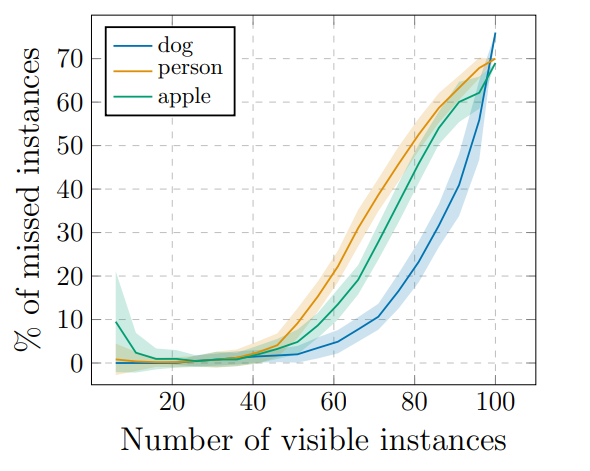

* object query 找物件的上限就是 $N$
* 如果一張圖裡有標的物件數量大於 60 屬於少數
* COCO 平均一張 7 個物件，最多 62 個。detr 會做 randomsizecrop 來增加物件。
* 資料集大部分資料一張圖裡有標的物件數量少於 50 ， detr 就在預測的時候看到 50 以下個物件時才會比較準。

* Fig. 5 \
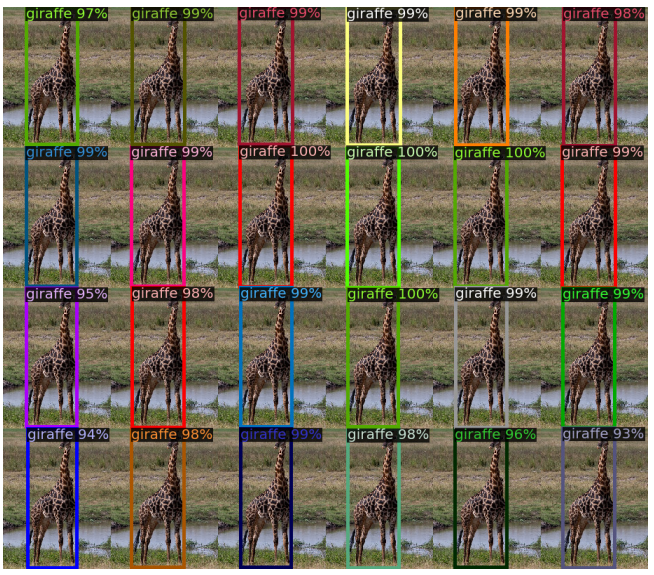

## Hands-on tutorial for DETR
[detr_attention.ipynb](https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb)
* In this notebook, we show-case how to:
    * use the pre-trained models that we provide to make predictions
    * visualize the attentions of the model to gain insights on the way it sees the images.

In [1]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [31]:
# COCO classes
CLASSES = [ 'fish',
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [4]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# load offical detr model from torchhub
# model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
# model.eval();

In [ ]:
# load pre trained model from local
num_classes = 1
checkpoint_p = r'checkpoint.pth'
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=False, num_classes=num_classes)
checkpoint = torch.load(checkpoint_p, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [6]:
# testing set image
test_img_p = r'2023_09_12_97.png'
im = Image.open(test_img_p)

In [25]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.5

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

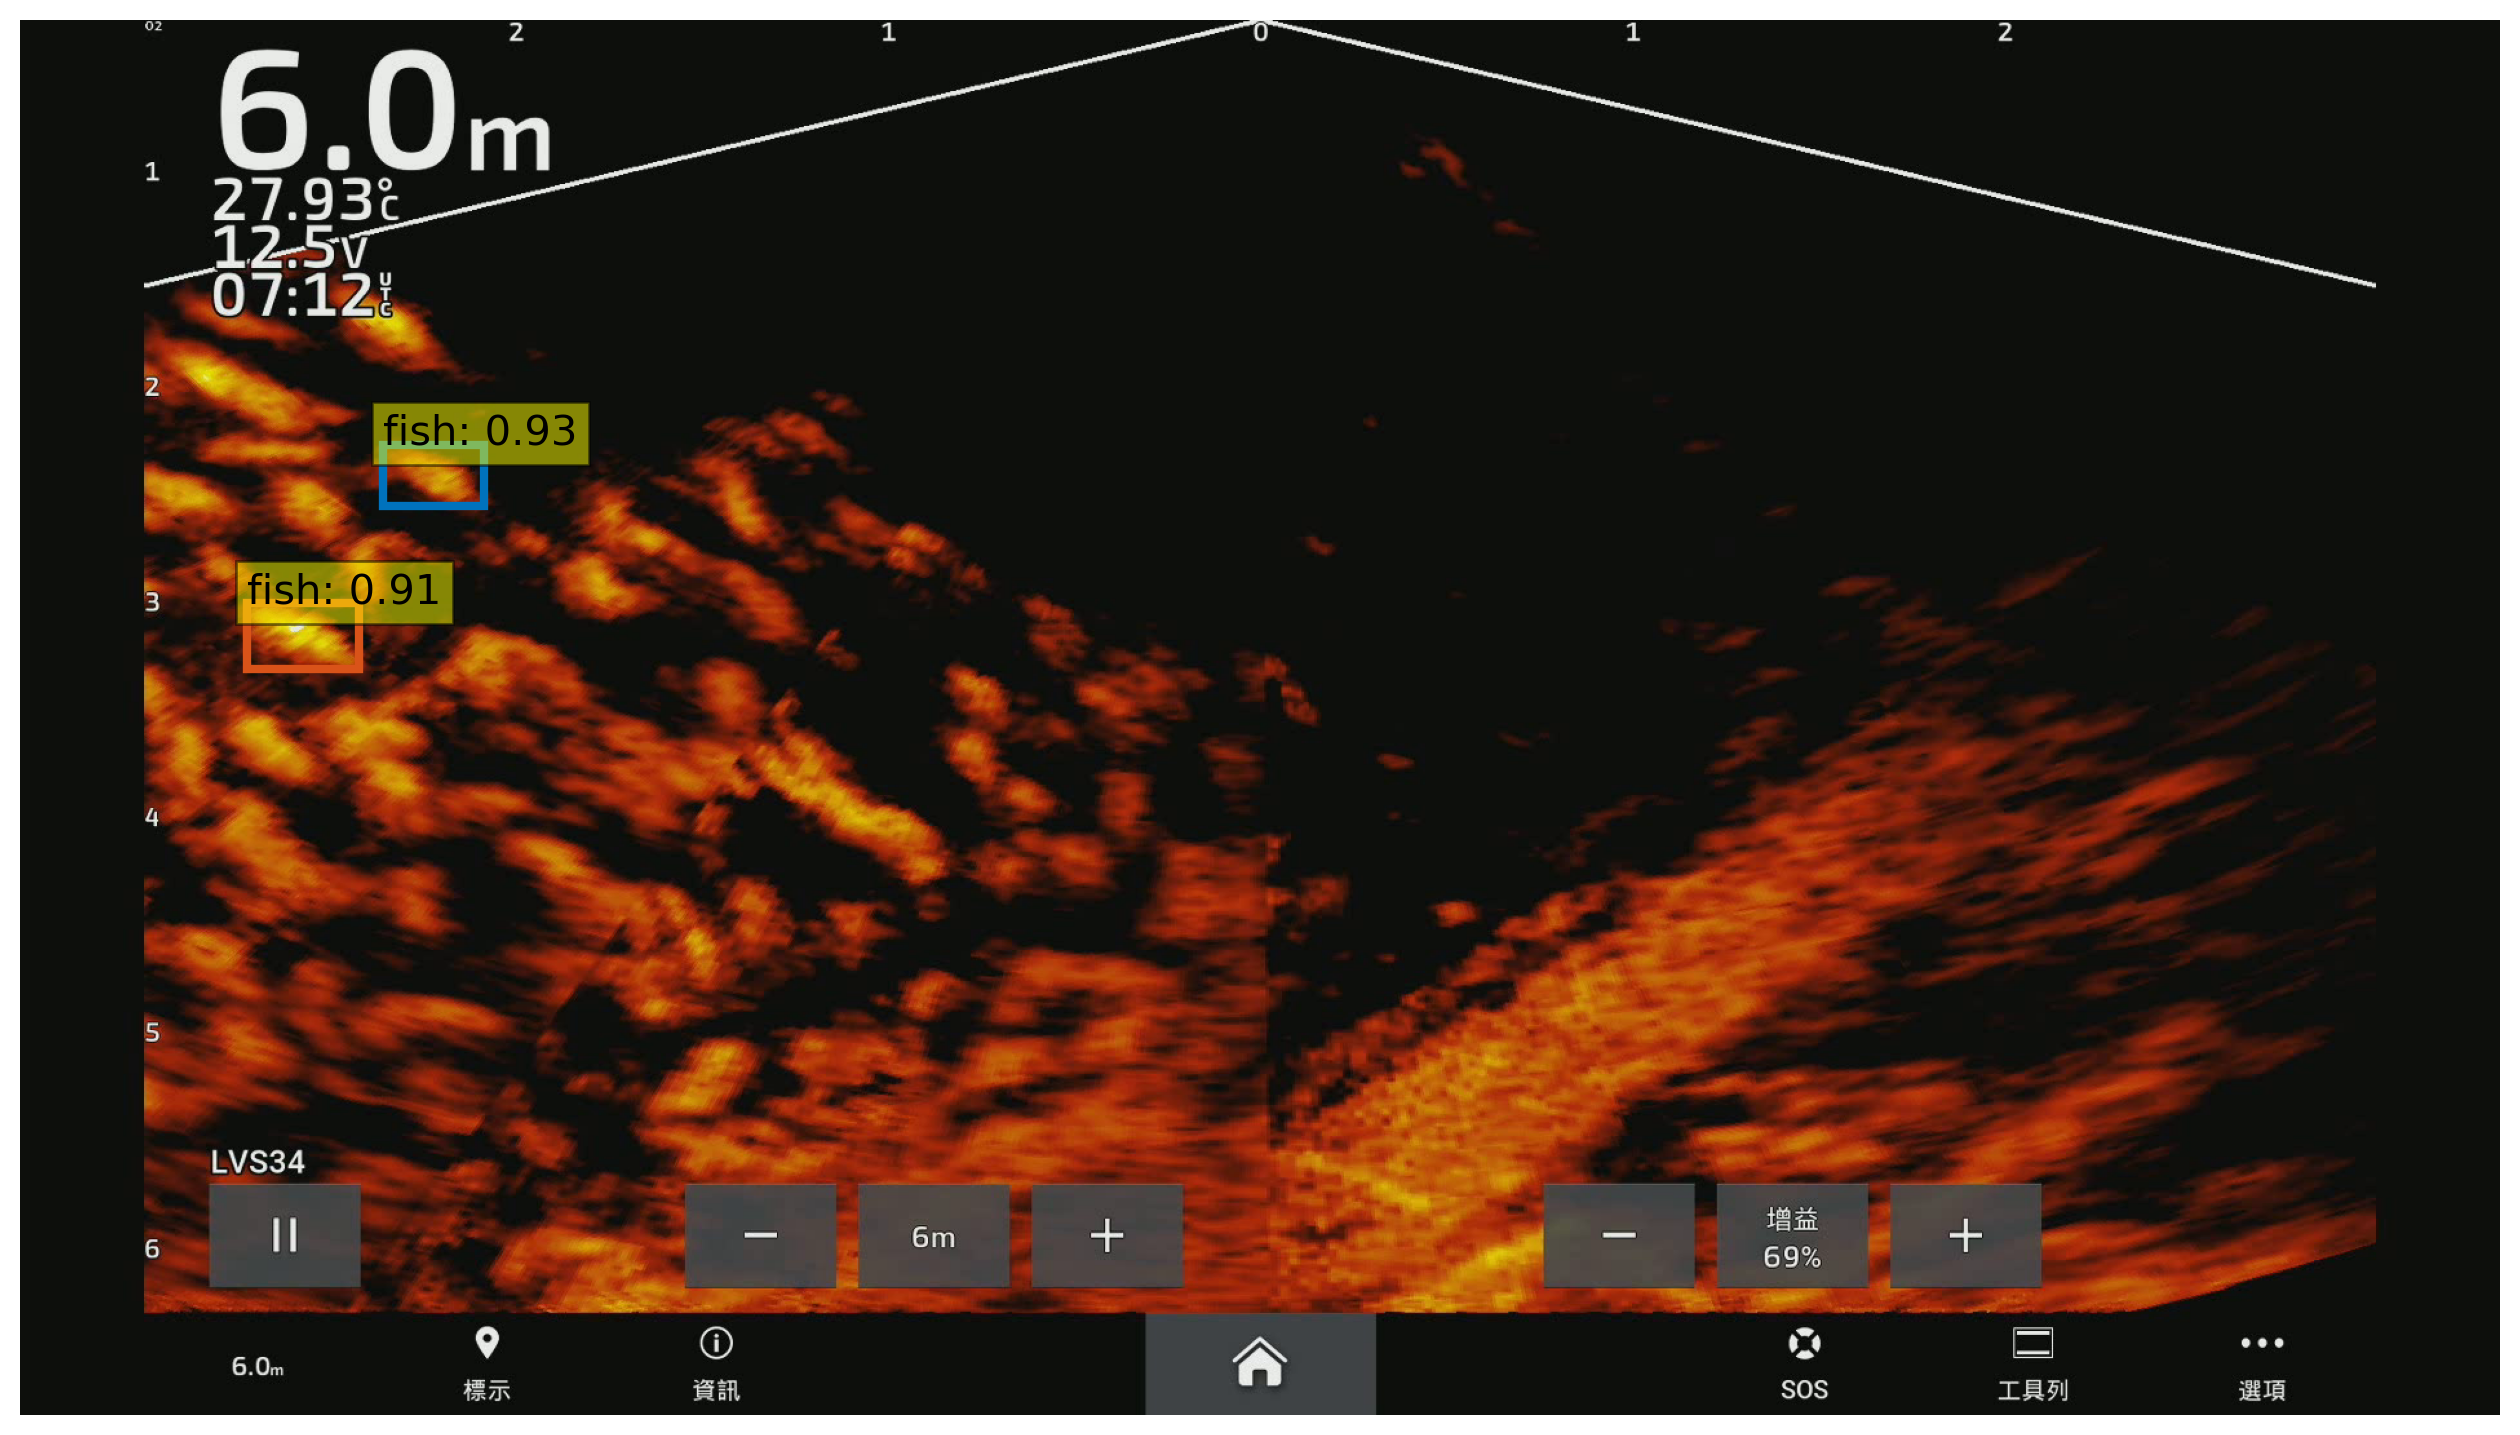

In [32]:
plot_results(im, probas[keep], bboxes_scaled)

In [27]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

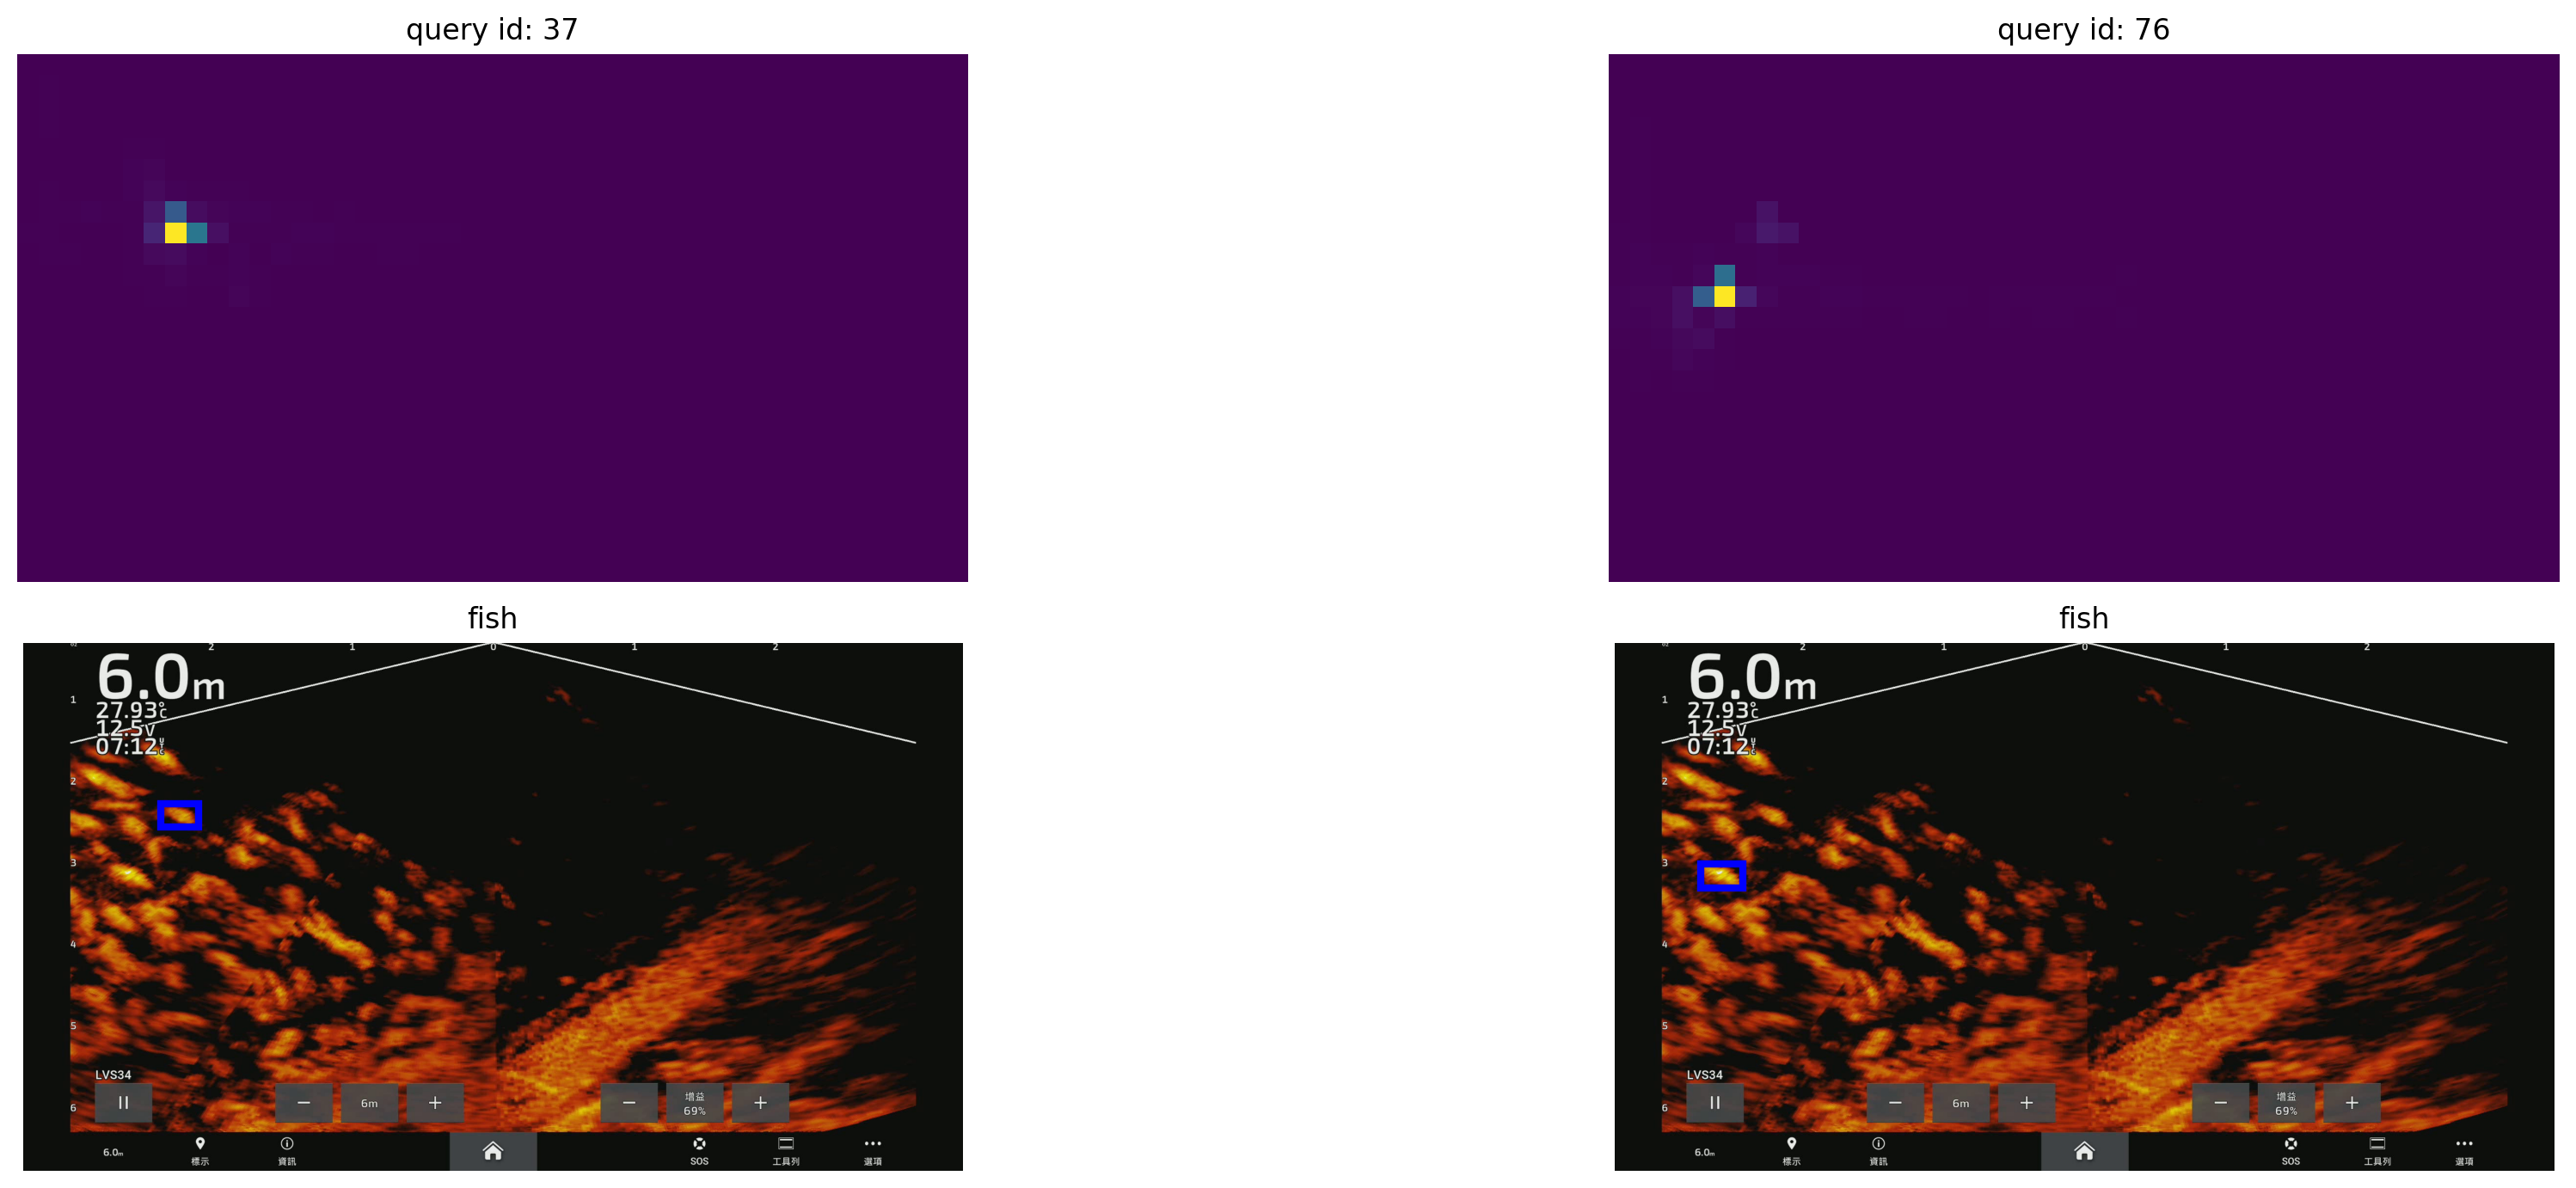

In [33]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

* Fig. 6 \
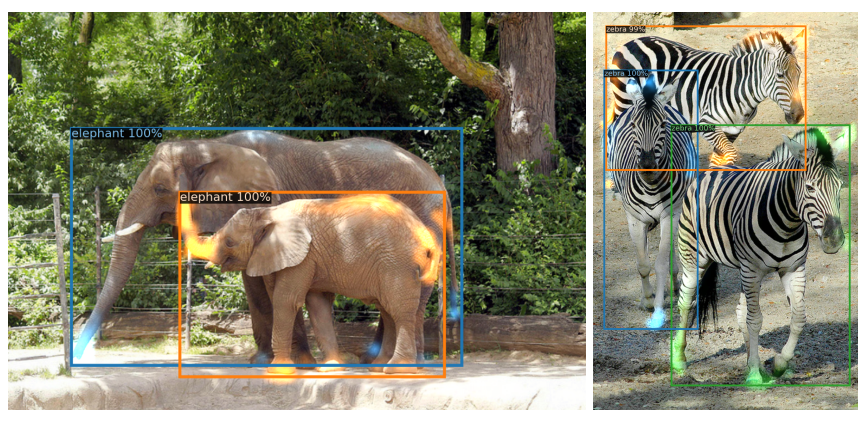

## DETR衍生論文
* 參考資料
    * [Object Detection with Transformers: A Review](https://arxiv.org/abs/2306.04670)

* **[Attention](#transformer)**
    * [Deformable DETR: Deformable Transformers for End-to-End Object Detection](https://arxiv.org/abs/2010.04159)
        * 做 attention 時會看除了 key 也會看 key 附近的資訊，改 [attention](#encoder) 的部份
        * 效果：訓練的 epoch 減少 10 倍，小物件的偵測效果提升
    * [AdaMixer: A Fast-Converging Query-Based Object Detector](https://arxiv.org/abs/2203.16507)
        * 在 decoder layer 裡面提供挑選出來的 multi-scale features
        * 效果：query 做 attention 主要看的會是 features，減少 position 對 query 的影響
    * [Recurrent Glimpse-based Decoder for Detection with Transformer](https://arxiv.org/abs/2112.04632)
        * 在 decoder layer 裡面會有 ROI 挑選出來的影像 feature 來做 attention
        * 效果：更容易找到影像中主要的物件
* **[Query](#decoder)**
    * [Efficient DETR: Improving End-to-End Object Detector with Dense Prior](https://arxiv.org/abs/2104.01318)
        * object query 不再是 random init ，而是用 top-K 的預測去回饋給 object query
        * 效果：正確找到物件的 object query ，可以直接回饋給 query ，不用等 attention 慢慢調整
    * [Conditional DETR for Fast Training Convergence](https://arxiv.org/abs/2108.06152)
        * decoder 學習 decoder embeddings 跟 object queries
    * [DAB-DETR: Dynamic Anchor Boxes are Better Queries for DETR](https://arxiv.org/abs/2201.12329)
        * 在 decoder 輸入的 object query 加上 anchor 一起用學的
    * [DN-DETR: Accelerate DETR Training by Introducing Query DeNoising](https://arxiv.org/abs/2203.01305)
        * a novel denoising training method，query 那裡加雜訊分成多組做 attention，attention 之後的要去找 anchor 配對
    * [DINO: DETR with Improved DeNoising Anchor Boxes for End-to-End Object Detection](https://arxiv.org/abs/2203.03605)
        * a contrastive way for denoising training, a mixed query selection method for anchor initialization, and a look forward twice scheme for box prediction.，改 [query](#encoder) 的部份
    * [DINOv2: Learning Robust Visual Features without Supervision](https://arxiv.org/abs/2304.07193)
* **[Attention & Query](#transformer)**
    * [Anchor DETR: Query Design for Transformer-Based Object Detection](https://arxiv.org/abs/2109.07107)
        * anchor point 經過 position encoder 當作 object query 輸入 decoder
* **[Matching](#matching--cost-matrix)**
    * [DETRs with Hybrid Matching](https://arxiv.org/abs/2207.13080)
        * 可以一對多。考慮 matching 的強度，降低沒有 matching 到帶來的逞罰

* Detic

## 問題

### Doing

- [ ] 如果 testing image 和 learned object queries 之間沒有關係，有沒有辦法去預測位置不同的物件(以魚為例來想)
- [ ] 可不可以處理 testing set 的資料跟 training set 的資料 影像上的位置關係有很大的不同
---
- [ ] label 出來的 bouding box 有沒有做 resize 或標準化
---
- [ ] 列出論文是在講改進 Detr 的哪一個部份（提供論文 title、出處、作者）
- [ ] Detr 可以改進的模型架構部份 在 Conclusion 部分有提到一些，找到對應的 code


### Done
- [X] 找程式碼實作與相對應的模型架構圖
- [X] FFN 用什麼去預測 bounding box
- [X] evaluate 會不會用到 hungarian algorithm Ans:不會
- [X] transformer encoder 輸入的資料結構，輸出的資料結構
- [X] transformer encoder 是在分析什麼資料。
- [X] transformer decoder 輸入的資料結構，輸出的資料結構
- [X] transformer decoder 是在分析什麼資料
- [X] encoder attention 是在分析什麼資料
- [X] Detr testing 輸入和輸出的資料結構、評量的單位(AP or ...)
- [X] 特別標註：object query 的 init ， data augmentation ， loss
- [X] Data augmentation
- [X] 如何學習 object query
- [X] 與文字版的 transformer 對應關係
- [X] 我們要如何設定 $N$ object queries 的數量，當我們的測試集裡一張圖裡物件上限數量是未知
- [X] object queries 的 init func 是用什麼

### To-DO
- [ ] 匈牙利演算法的先決條件，用graph來解釋
- [ ] 匈牙利演算法(Hungarian algorithm)實作方法
- [ ] 匈牙利 vs non maxima，比較匈牙利演算法Cost 跟 anchor
- [ ] 嘗試用白話文描述 Detr
- [ ] 嘗試用白話文描述 mask rcnn
- [ ] 嘗試用白話文描述 Detr 與 mask rcnn 之間的差別
- [ ] segmentation head 的輸入資料結構，輸出資料結構
- [ ] segmentation head 是靠什麼分析出 mask
- [ ] Detr training loss 的大小
- [ ] object queries 很重要跟卷積不一樣的地方，為什要有這個。對偵測要有什麼幫助。